In [1]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)



# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

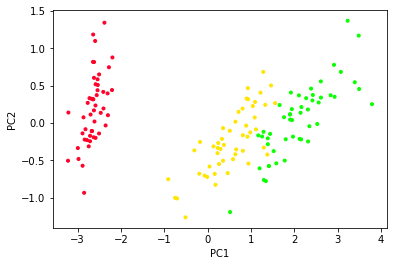

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

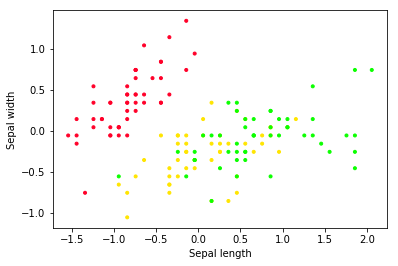

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [9]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [10]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [11]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [12]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [13]:
set_truth = False

In [14]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [15]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

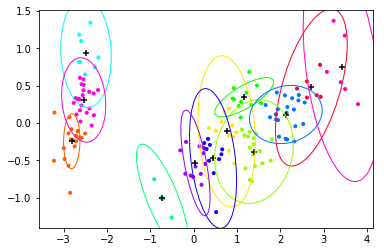

In [16]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [17]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


In [18]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [19]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
    model.optimize_full(init_global_free_param,
        init_max_iter=100,
        final_max_iter=500)
t_newton = time.time() - t0

print('done. ')

Iter: 0	 RMSE: 5.4171664084976205	 Objective: 4865.172927669948
Iter: 10	 RMSE: 10.663487726019486	 Objective: 3139.840570638689
Iter: 20	 RMSE: 11.537717178033818	 Objective: 2263.0443955658193
Iter: 30	 RMSE: 11.030946757019787	 Objective: 640.5224954576282
Iter: 40	 RMSE: 13.031531993740426	 Objective: -31.385781448850253
Iter: 50	 RMSE: 9.900303204544576	 Objective: -224.24842459009497
Iter: 60	 RMSE: 8.887730788323266	 Objective: -287.76935205287725
Iter: 70	 RMSE: 9.168777840432464	 Objective: -308.43296439711247
Iter: 80	 RMSE: 9.204747934680391	 Objective: -313.72592232799235
Iter: 90	 RMSE: 9.148647377214733	 Objective: -317.0908408178151
Iter: 100	 RMSE: 9.168596158824302	 Objective: -319.44978597507946
         Current function value: -320.229628
         Iterations: 100
         Function evaluations: 110
         Gradient evaluations: 110
Iter: 110	 RMSE: 9.147545898750307	 Objective: -320.229627514379
Iter: 120	 RMSE: 9.076998619823613	 Objective: -322.56162721193607
Iter:

In [20]:
newton_results = deepcopy(model)

In [21]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [22]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [23]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

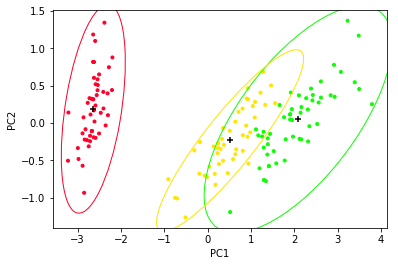

In [24]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [25]:
# plt.scatter(pc_features[bnp_clusters == 0, 0], pc_features[bnp_clusters == 0, 1])

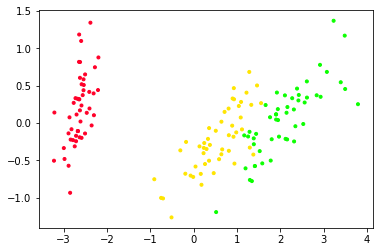

In [26]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

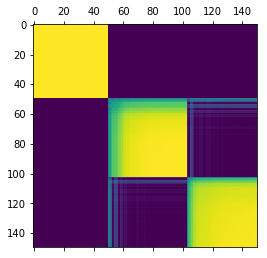

In [27]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [28]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

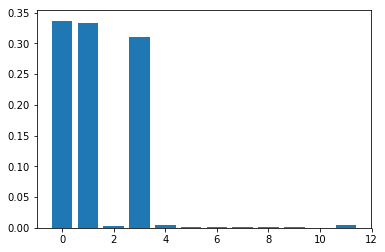

In [29]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

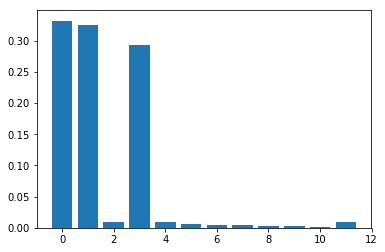

In [30]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  2.,   0.,   1.,   1.,   1.,   5.,   2.,   2.,   6., 130.]),
 array([0.44352936, 0.49917643, 0.55482349, 0.61047055, 0.66611762,
        0.72176468, 0.77741174, 0.83305881, 0.88870587, 0.94435294,
        1.        ]),
 <a list of 10 Patch objects>)

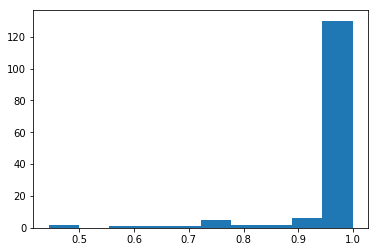

In [31]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Functional sensitivity

In [32]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [33]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [34]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


0.07230487288465931 2452.4187642002566


In [35]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return common_modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [36]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return common_modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))
for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

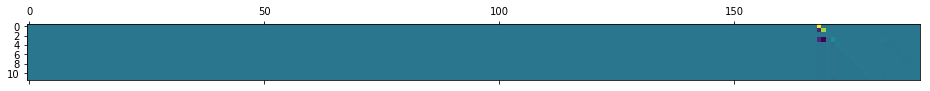

In [37]:
plt.matshow(g_eta)

In [38]:
model.set_from_global_free_par(best_param)
e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

for i in range(k_approx): 
    assert np.abs(get_kth_weight_from_free_param(model, best_param, i) - \
                        common_modeling_lib.get_mixture_weights(e_sticks)[i]) < 1e-12

In [39]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


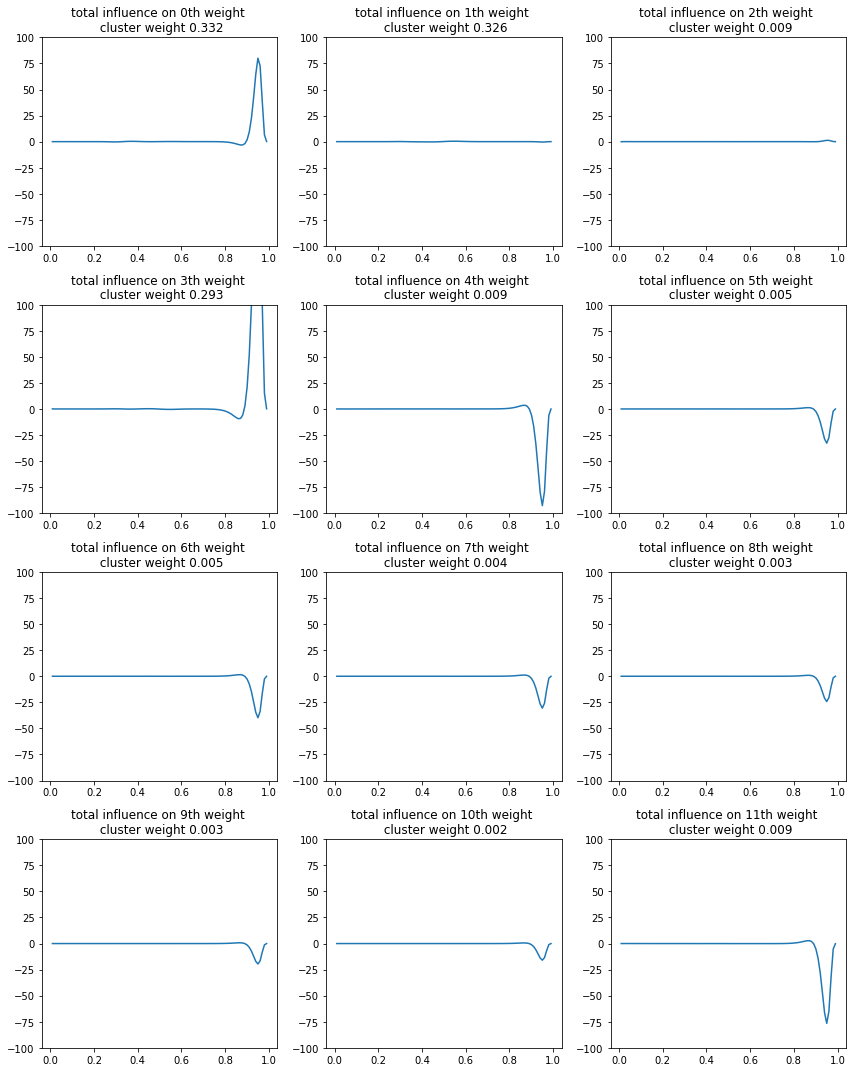

In [40]:
f, axarr = plt.subplots(4, 3, figsize=(12, 15))

for k in range(k_approx): 
    
    indx1 = int(np.floor(k / 3))
    indx2 = k % 3
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('total influence on {}th weight \n cluster weight {}'.format(
        k, round(weights[k], 3)))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

# f.delaxes(axarr[5][1])

f.tight_layout()


In [41]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [42]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

In [43]:
theta = np.linspace(0.01, 0.99, 100)
influence_n_clust = np.zeros((k_approx, len(theta)))

for k in range(k_approx - 1): 
    influence_n_clust[k, :] += np.dot(np.array([g_eta_nclust]), \
                                           linear_sens.influence_function(theta, k)).flatten()


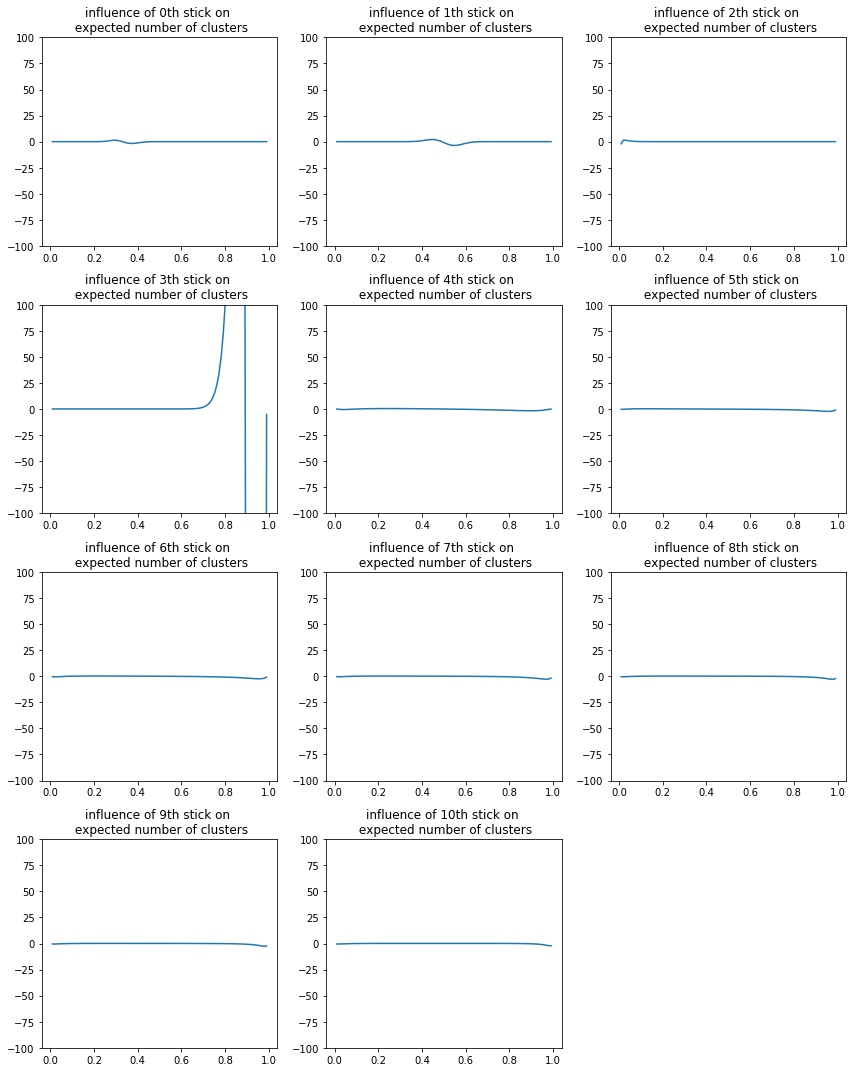

In [44]:
f, axarr = plt.subplots(4, 3, figsize=(12, 15))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 3))
    indx2 = k % 3
    axarr[indx1, indx2].plot(theta, influence_n_clust[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('influence of {}th stick on \n expected number of clusters'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[3][2])

f.tight_layout()


In [45]:
total_influence_n_clust = np.sum(influence_n_clust, axis = 0)

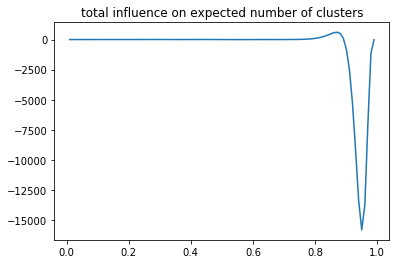

In [46]:
plt.plot(theta, total_influence_n_clust)
plt.title('total influence on expected number of clusters')

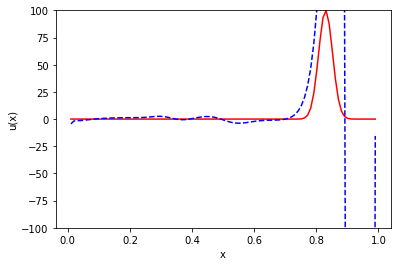

In [50]:
# lets choose a perturbation 
epsilon = 0.05

# u = lambda x : np.exp(-(x - 0.97)**2 / 0.01)
u = lambda x : np.exp(-(x - 0.83)**2 / 0.001)

plt.plot(theta, u(theta) * 100, color = 'red')
plt.plot(theta, total_influence_n_clust, '--', color = 'blue')
plt.ylim((-100, 100))
plt.ylabel('u(x)')
plt.xlabel('x')

In [48]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x) * epsilon)

In [49]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [50]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : u(x) * epsilon)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.50368921496886
Iter: 10	 RMSE: 9.010937709908532	 Objective: -338.59027257956745
Iter: 20	 RMSE: 9.010723209203373	 Objective: -338.6050850800909
Iter: 30	 RMSE: 8.99586772290325	 Objective: -338.63904189336097
Iter: 40	 RMSE: 8.992721122434643	 Objective: -338.658029217828
Iter: 50	 RMSE: 8.989980595268756	 Objective: -338.6621812264604
Iter: 60	 RMSE: 8.990256273854216	 Objective: -338.6626348957416
Iter: 70	 RMSE: 8.990254045433964	 Objective: -338.6626491098153
Iter: 80	 RMSE: 8.990265360862043	 Objective: -338.66264944495225
Optimization terminated successfully.
         Current function value: -338.662649
         Iterations: 69
         Function evaluations: 87
         Gradient evaluations: 87
         Current function value: -338.662649
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00012136770883436621, f_diff = 6.394884621840902e-11


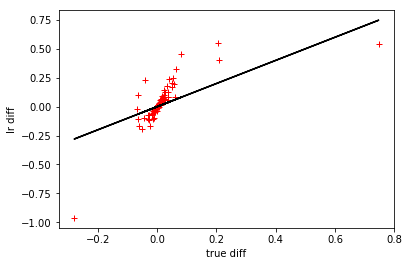

In [51]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


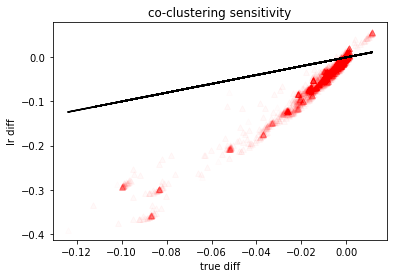

In [52]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


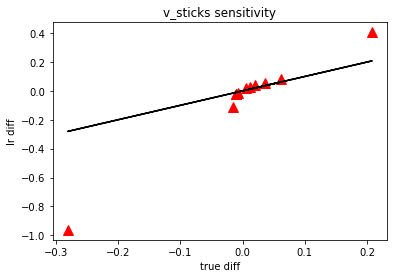

In [53]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


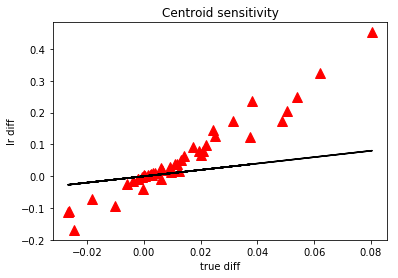

In [54]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')


In [55]:
get_e_number_clusters_from_free_par(model, best_param)

6.295933317235013

In [56]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pert_u_opt_free_param))

perturbed e_number_clusters: 6.719489790838102


In [57]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 7.68998800185088


In [58]:
# Test this perturbation for a range of epsilons

In [70]:
# epsilons = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
epsilons = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]

In [71]:
pert_opt_free_param_list = []

# re-optimize for each epsilon
for i in tqdm(range(len(epsilons))): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    model_u_pert = gmm_utils.DPGaussianMixture(
        model.y, model.k_approx, model.prior_params, gh_deg = 8, \
        use_bnp_prior = model.vb_params.use_bnp_prior, \
        use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
        u = lambda x : u(x) * epsilons[i])
    
    pert_opt_free_param_list.append(
        model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = True)[0])


  0%|          | 0/10 [00:00<?, ?it/s]

optimizing when epsilon = 0.02
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.28021081767224
Iter: 10	 RMSE: 9.017229603568147	 Objective: -338.3197593913746
Iter: 20	 RMSE: 9.016786047754708	 Objective: -338.3245220388026
Iter: 30	 RMSE: 9.011361806952744	 Objective: -338.33134665398245
Iter: 40	 RMSE: 9.009004245343226	 Objective: -338.33438713878235
Iter: 50	 RMSE: 9.008692080917664	 Objective: -338.33468662085653
Iter: 60	 RMSE: 9.008742410410392	 Objective: -338.3347625313931
Iter: 70	 RMSE: 9.008706931605031	 Objective: -338.3347657704029
Iter: 80	 RMSE: 9.008699891787021	 Objective: -338.3347658222729
Optimization terminated successfully.
         Current function value: -338.334766
         Iterations: 67
         Function evaluations: 85
         Gradient evaluations: 85


 10%|█         | 1/10 [00:12<01:53, 12.61s/it]

         Current function value: -338.334766
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0001436707068965692, f_diff = 8.58335624798201e-11
optimizing when epsilon = 0.05
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.50368921496886
Iter: 10	 RMSE: 9.010937709908532	 Objective: -338.59027257956745
Iter: 20	 RMSE: 9.010723209203373	 Objective: -338.6050850800909
Iter: 30	 RMSE: 8.99586772290325	 Objective: -338.63904189336097
Iter: 40	 RMSE: 8.992721122434643	 Objective: -338.658029217828
Iter: 50	 RMSE: 8.989980595268756	 Objective: -338.6621812264604
Iter: 60	 RMSE: 8.990256273854216	 Objective: -338.6626348957416
Iter: 70	 RMSE: 8.990254045433964	 Objective: -338.6626491098153
Iter: 80	 RMSE: 8.990265360862043	 Objective: -338.66264944495225
Optimization terminated successfully.
         Current function value: -338.662649
         Iterations: 69
         Function evaluations: 87
      

 20%|██        | 2/10 [00:25<01:40, 12.62s/it]

         Current function value: -338.662649
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00012136770883436621, f_diff = 6.394884621840902e-11
optimizing when epsilon = 0.1
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.7472134049373
Iter: 10	 RMSE: 9.005591251171118	 Objective: -338.8882226092431
Iter: 20	 RMSE: 9.001087912617857	 Objective: -338.93875142912304
Iter: 30	 RMSE: 8.985313713846041	 Objective: -339.0276705354495
Iter: 40	 RMSE: 8.986949761421371	 Objective: -339.06942913267477
Iter: 50	 RMSE: 8.983576988051718	 Objective: -339.0921330449451
Iter: 60	 RMSE: 8.98340993816409	 Objective: -339.0923602810762
Iter: 70	 RMSE: 8.98334426293801	 Objective: -339.09237478244324
Iter: 80	 RMSE: 8.98336209068994	 Objective: -339.0923752865549
Optimization terminated successfully.
         Current function value: -339.092375
         Iterations: 73
         Function evaluations: 90
       

 30%|███       | 3/10 [00:37<01:27, 12.55s/it]

         Current function value: -339.092375
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 5.115241088344272e-05, f_diff = 3.0809133022557944e-11
optimizing when epsilon = 0.15
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.91881828140686
Iter: 10	 RMSE: 8.998420972061178	 Objective: -339.1197316141538
Iter: 20	 RMSE: 8.997087218064177	 Objective: -339.16267109180205
Iter: 30	 RMSE: 8.987054829355008	 Objective: -339.3057256034524
Iter: 40	 RMSE: 8.985387100337267	 Objective: -339.40150295034357
Iter: 50	 RMSE: 8.981780568736243	 Objective: -339.40857722795545
Iter: 60	 RMSE: 8.982051044944617	 Objective: -339.40910654945765
Iter: 70	 RMSE: 8.981958773917619	 Objective: -339.4091234238896
Iter: 80	 RMSE: 8.981974485654629	 Objective: -339.40912435464116
Iter: 90	 RMSE: 8.98197346475061	 Objective: -339.4091243722186
Optimization terminated successfully.
         Current function value: -339.4

 40%|████      | 4/10 [00:50<01:16, 12.71s/it]

         Current function value: -339.409124
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0002006102814369837, f_diff = 2.1748292056145146e-10
optimizing when epsilon = 0.2
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.05302241147825
Iter: 10	 RMSE: 8.994321974890582	 Objective: -339.3018335208521
Iter: 20	 RMSE: 8.995759715136813	 Objective: -339.35464521584765
Iter: 30	 RMSE: 8.983891554734887	 Objective: -339.536651307114
Iter: 40	 RMSE: 8.983897794991565	 Objective: -339.633128250727
Iter: 50	 RMSE: 8.981773083441634	 Objective: -339.6536666978476
Iter: 60	 RMSE: 8.980852935043444	 Objective: -339.65587229822046
Iter: 70	 RMSE: 8.98075733616009	 Objective: -339.65588921142614
Iter: 80	 RMSE: 8.980780833358038	 Objective: -339.6558900122177
Iter: 90	 RMSE: 8.980772011174473	 Objective: -339.65589004547434
Optimization terminated successfully.
         Current function value: -339.65589

 50%|█████     | 5/10 [01:06<01:06, 13.25s/it]

         Current function value: -339.655890
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00018490486255061535, f_diff = 1.2641976354643703e-10
optimizing when epsilon = 0.25
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.1640376653028
Iter: 10	 RMSE: 8.993892513490572	 Objective: -339.44680317111215
Iter: 20	 RMSE: 8.993813380804477	 Objective: -339.53497981665737
Iter: 30	 RMSE: 8.979425758696783	 Objective: -339.7677385210166
Iter: 40	 RMSE: 8.983467251821528	 Objective: -339.848785650799
Iter: 50	 RMSE: 8.980827885206075	 Objective: -339.8563633197472
Iter: 60	 RMSE: 8.980036504042971	 Objective: -339.8565380810652
Iter: 70	 RMSE: 8.980101094186715	 Objective: -339.85654163152907
Iter: 80	 RMSE: 8.98008386487474	 Objective: -339.85654182749926
Optimization terminated successfully.
         Current function value: -339.856542
         Iterations: 72
         Function evaluations: 89
   

 60%|██████    | 6/10 [01:18<00:52, 13.16s/it]

         Current function value: -339.856542
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00012390038622317625, f_diff = 8.0831341620069e-11
optimizing when epsilon = 0.3
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.2591684232211
Iter: 10	 RMSE: 8.993930940307965	 Objective: -339.5711302030435
Iter: 20	 RMSE: 8.994636954559159	 Objective: -339.6738686198038
Iter: 30	 RMSE: 8.977412297278953	 Objective: -339.94853001922394
Iter: 40	 RMSE: 8.98265707298431	 Objective: -340.0195341391715
Iter: 50	 RMSE: 8.980143256535467	 Objective: -340.02518486389215
Iter: 60	 RMSE: 8.979587112336809	 Objective: -340.02535878973595
Iter: 70	 RMSE: 8.979641888766338	 Objective: -340.0253653611138
Iter: 80	 RMSE: 8.979637831659609	 Objective: -340.02536566695704
Optimization terminated successfully.
         Current function value: -340.025366
         Iterations: 72
         Function evaluations: 87
      

 70%|███████   | 7/10 [01:31<00:39, 13.03s/it]

         Current function value: -340.025366
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00018395396894515782, f_diff = 2.0196466721245088e-10
optimizing when epsilon = 0.4
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.41732091630627
Iter: 10	 RMSE: 8.992886588491247	 Objective: -339.7804830180072
Iter: 20	 RMSE: 8.994612941900382	 Objective: -339.8956599256542
Iter: 30	 RMSE: 8.976516668087022	 Objective: -340.21064087096295
Iter: 40	 RMSE: 8.982851528367538	 Objective: -340.3043665071692
Iter: 50	 RMSE: 8.980540857650816	 Objective: -340.30761909254227
Iter: 60	 RMSE: 8.980064793247307	 Objective: -340.307813098842
Iter: 70	 RMSE: 8.979995379334312	 Objective: -340.30781492574596
Iter: 80	 RMSE: 8.980002272640924	 Objective: -340.30781499166943
Optimization terminated successfully.
         Current function value: -340.307815
         Iterations: 74
         Function evaluations: 89
  

 80%|████████  | 8/10 [01:44<00:26, 13.10s/it]

         Current function value: -340.307815
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00016746893419713723, f_diff = 1.0459189070388675e-10
optimizing when epsilon = 0.5
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.5467870689158
Iter: 10	 RMSE: 8.991700110199856	 Objective: -339.9518475740506
Iter: 20	 RMSE: 8.99308724647923	 Objective: -340.0965910393531
Iter: 30	 RMSE: 8.988538878598858	 Objective: -340.42038212900457
Iter: 40	 RMSE: 8.983900429040172	 Objective: -340.519099706664
Iter: 50	 RMSE: 8.980602607439998	 Objective: -340.52649388814893
Iter: 60	 RMSE: 8.979746765618001	 Objective: -340.52704114691664
Iter: 70	 RMSE: 8.979665736729114	 Objective: -340.5270448257312
Iter: 80	 RMSE: 8.97967758005799	 Objective: -340.5270449469535
Optimization terminated successfully.
         Current function value: -340.527045
         Iterations: 69
         Function evaluations: 90
      

 90%|█████████ | 9/10 [01:58<00:13, 13.11s/it]

         Current function value: -340.527045
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.000318067070803476, f_diff = 3.306013240944594e-10
optimizing when epsilon = 0.6
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.657000437883
Iter: 10	 RMSE: 8.991125936693894	 Objective: -340.0952979966913
Iter: 20	 RMSE: 8.995962949417986	 Objective: -340.18038290444304
Iter: 30	 RMSE: 8.983222053979217	 Objective: -340.5896677290872
Iter: 40	 RMSE: 8.983685203819483	 Objective: -340.3022557461429
Iter: 50	 RMSE: 8.980417874642887	 Objective: -340.70847210843493
Iter: 60	 RMSE: 8.979521621761108	 Objective: -340.7088294180888
Iter: 70	 RMSE: 8.97947063113104	 Objective: -340.7088330778416
Iter: 80	 RMSE: 8.979471366079393	 Objective: -340.7088332164751
Optimization terminated successfully.
         Current function value: -340.708833
         Iterations: 71
         Function evaluations: 89
         

100%|██████████| 10/10 [02:10<00:00, 13.06s/it]

         Current function value: -340.708833
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00021565664493013777, f_diff = 2.22655671677785e-10


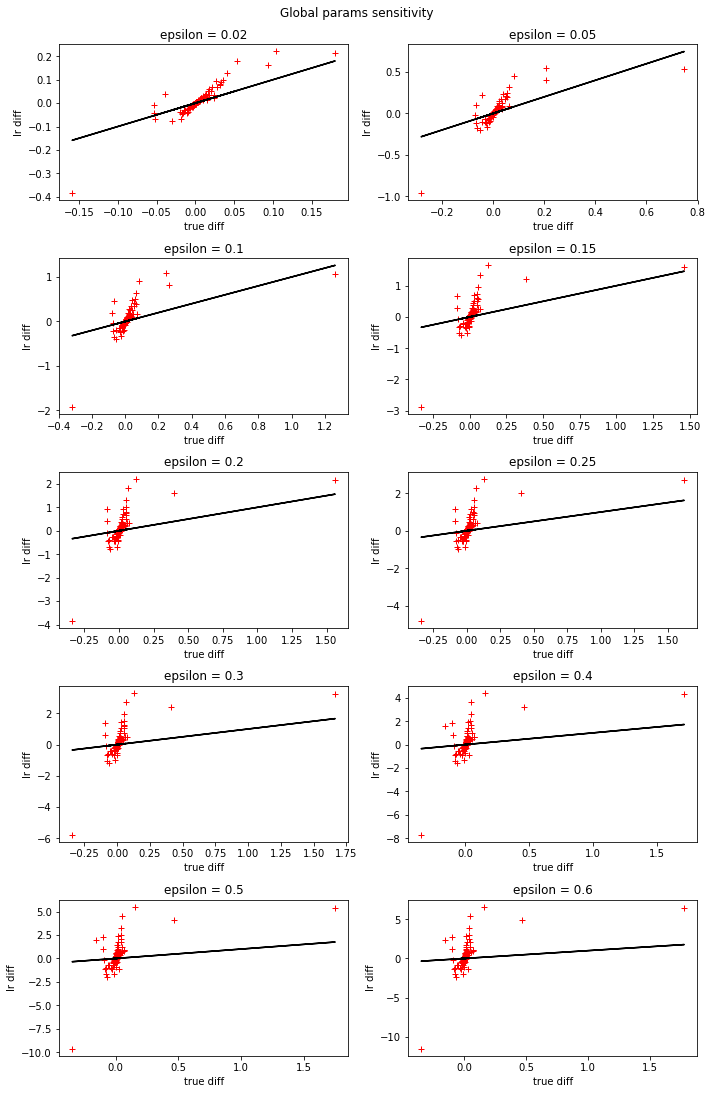

In [72]:
# check global params

linear_sens.moment_model.set_moments_from_free_par(best_param)

fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x))

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
        
    # get linear response global free params
    lr_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])

    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


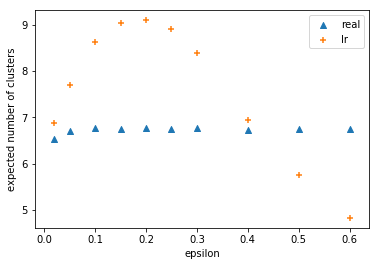

In [73]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.legend(('real', 'lr'))
# plt.xlim((0.0, 0.026))

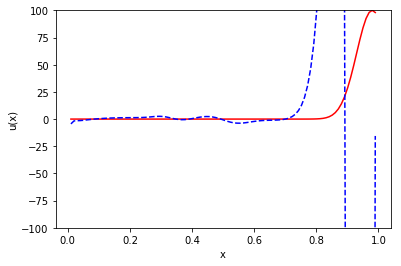

In [53]:
# lets choose a perturbation 
epsilon = 0.0005

u = lambda x : np.exp(-(x - 0.98)**2 / 0.005)
# u = lambda x : np.exp(-(x - 0.83)**2 / 0.001)

plt.plot(theta, u(theta) * 100, color = 'red')
plt.plot(theta, total_influence_n_clust, '--', color = 'blue')
plt.ylim((-100, 100))
plt.xlabel('x')
plt.ylabel('u(x)')

In [64]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x) * epsilon)

In [65]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [66]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : u(x) * epsilon)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.1217750146888
Iter: 10	 RMSE: 9.040810191997362	 Objective: -338.14016867059064
Iter: 20	 RMSE: 9.043075188120396	 Objective: -338.14850324455745
Iter: 30	 RMSE: 9.054733330050459	 Objective: -338.1705994231412
Iter: 40	 RMSE: 9.075916195831432	 Objective: -338.16199161813057
Iter: 50	 RMSE: 9.101033770891823	 Objective: -338.20742628914195
Iter: 60	 RMSE: 9.111785568575243	 Objective: -338.2342072898762
Iter: 70	 RMSE: 9.072377568233433	 Objective: -338.27300727686816
Iter: 80	 RMSE: 9.066076640217522	 Objective: -338.2841372879487
Iter: 90	 RMSE: 9.066221732773279	 Objective: -338.28452423324956
Iter: 100	 RMSE: 9.066266039166102	 Objective: -338.28453044476686
Iter: 110	 RMSE: 9.066262656392272	 Objective: -338.28453060923283
Optimization terminated successfully.
         Current function value: -338.284531
         Iterations: 96
         Function evaluations: 116
         Gradient evaluations: 116
Optimization terminated successful

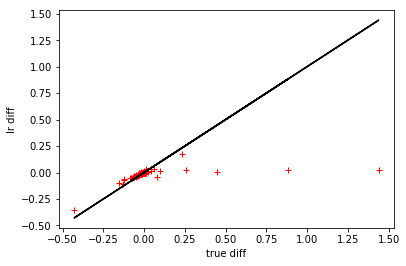

In [67]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


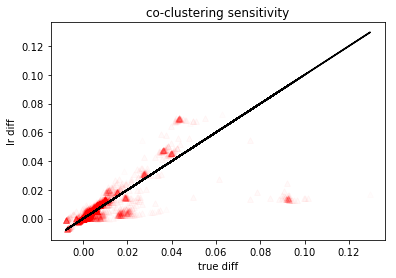

In [68]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


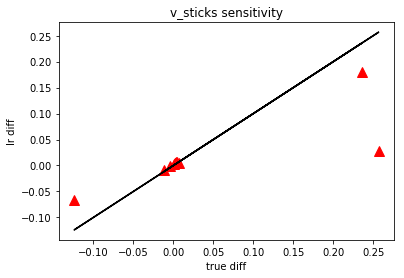

In [69]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


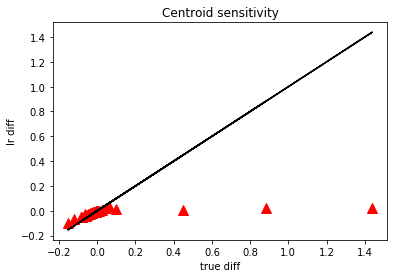

In [70]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')


In [71]:
get_e_number_clusters_from_free_par(model, best_param)

6.290156369623471

In [72]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pert_u_opt_free_param))

perturbed e_number_clusters: 5.986517918689309


In [73]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 6.03851504556403


In [74]:
# Test this perturbation for a range of epsilons

In [194]:
epsilons = [0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]

In [195]:
pert_opt_free_param_list2 = []

# re-optimize for each epsilon
for i in tqdm(range(len(epsilons))): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    model_u_pert = gmm_utils.DPGaussianMixture(
        model.y, model.k_approx, model.prior_params, gh_deg = 8, \
        use_bnp_prior = model.vb_params.use_bnp_prior, \
        use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
        u = lambda x : u(x) * epsilons[i])
    
    pert_opt_free_param_list2.append(
        model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = True)[0])


  0%|          | 0/10 [00:00<?, ?it/s]

optimizing when epsilon = 5e-05
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0570310664953
Iter: 10	 RMSE: 9.029308520884555	 Objective: -338.05728114638504
Iter: 20	 RMSE: 9.029408607733652	 Objective: -338.0573757253344
Iter: 30	 RMSE: 9.030058314015942	 Objective: -338.05750481963486
Iter: 40	 RMSE: 9.030090763576782	 Objective: -338.05752684458423
Iter: 50	 RMSE: 9.030279183757752	 Objective: -338.05753903459134
Iter: 60	 RMSE: 9.030301998733698	 Objective: -338.05754122735095
Iter: 70	 RMSE: 9.030292871605642	 Objective: -338.0575413264758
Optimization terminated successfully.
         Current function value: -338.057541
         Iterations: 63
         Function evaluations: 79
         Gradient evaluations: 79
Iter: 80	 RMSE: 9.030295086165989	 Objective: -338.0575413298958


 10%|█         | 1/10 [00:12<01:49, 12.20s/it]

         Current function value: -338.057541
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00010065655288687113, f_diff = 7.190692485892214e-11
optimizing when epsilon = 0.0001
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.06545369247414
Iter: 10	 RMSE: 9.030567074083859	 Objective: -338.066390331885
Iter: 20	 RMSE: 9.030803143702157	 Objective: -338.0667507067962
Iter: 30	 RMSE: 9.032351628322795	 Objective: -338.0672717024152
Iter: 40	 RMSE: 9.032537307930822	 Objective: -338.0673898659413
Iter: 50	 RMSE: 9.032662639756634	 Objective: -338.067434641844
Iter: 60	 RMSE: 9.032748461726602	 Objective: -338.06744271221623
Iter: 70	 RMSE: 9.032734068158733	 Objective: -338.06744306524865
Iter: 80	 RMSE: 9.032741023589653	 Objective: -338.06744308087764
Optimization terminated successfully.
         Current function value: -338.067443
         Iterations: 67
         Function evaluations: 82
  

 20%|██        | 2/10 [00:24<01:39, 12.48s/it]

         Current function value: -338.067443
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 6.756816259915034e-05, f_diff = 2.8819613362429664e-11
optimizing when epsilon = 0.00015
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.07344908638015
Iter: 10	 RMSE: 9.031810276517891	 Objective: -338.0754508212575
Iter: 20	 RMSE: 9.03220968320011	 Objective: -338.07623713693783
Iter: 30	 RMSE: 9.034784593331397	 Objective: -338.077347181707
Iter: 40	 RMSE: 9.035108900826605	 Objective: -338.07761607969996
Iter: 50	 RMSE: 9.035350566595334	 Objective: -338.07786335215656
Iter: 60	 RMSE: 9.03545939804781	 Objective: -338.0778821878633
Iter: 70	 RMSE: 9.03541544310543	 Objective: -338.0778835134819
Iter: 80	 RMSE: 9.035419408439694	 Objective: -338.07788358739094
Optimization terminated successfully.
         Current function value: -338.077884
         Iterations: 68
         Function evaluations: 86
  

 30%|███       | 3/10 [00:40<01:34, 13.55s/it]

Optimization terminated successfully.
         Current function value: -338.077884
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 7.134191310171069e-05, f_diff = 3.149125404888764e-11
optimizing when epsilon = 0.0002
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0810937062233
Iter: 10	 RMSE: 9.03305081292375	 Objective: -338.08450588185
Iter: 20	 RMSE: 9.033639314760327	 Objective: -338.08587492139304
Iter: 30	 RMSE: 9.037342592729896	 Objective: -338.0879150820974
Iter: 40	 RMSE: 9.037799893078907	 Objective: -338.0888355322121
Iter: 50	 RMSE: 9.038080081471847	 Objective: -338.0889408161269
Iter: 60	 RMSE: 9.03846726027866	 Objective: -338.0889964575895
Iter: 70	 RMSE: 9.038398141294488	 Objective: -338.0890046859478
Iter: 80	 RMSE: 9.038412019243871	 Objective: -338.08900478826587
Optimization terminated successfully.
         Current function value: -338.089005
         Iterations: 67
   

 40%|████      | 4/10 [00:55<01:22, 13.81s/it]

         Current function value: -338.089005
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.000131061762481344, f_diff = 7.963762982399203e-11
optimizing when epsilon = 0.00025
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0884397685521
Iter: 10	 RMSE: 9.034297112827785	 Objective: -338.09358701158595
Iter: 20	 RMSE: 9.03509990972343	 Objective: -338.0956959837753
Iter: 30	 RMSE: 9.04034142281375	 Objective: -338.0989883759262
Iter: 40	 RMSE: 9.040965031747147	 Objective: -338.1006886852681
Iter: 50	 RMSE: 9.041602717107413	 Objective: -338.10090677701004
Iter: 60	 RMSE: 9.041784479654075	 Objective: -338.1009822140524
Iter: 70	 RMSE: 9.041843737346438	 Objective: -338.10099004044605
Iter: 80	 RMSE: 9.041845006071732	 Objective: -338.10099035955443


 50%|█████     | 5/10 [01:10<01:10, 14.06s/it]

Optimization terminated successfully.
         Current function value: -338.100990
         Iterations: 67
         Function evaluations: 85
         Gradient evaluations: 85
         Current function value: -338.100990
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00021580363743795646, f_diff = 1.8752643882180564e-10
optimizing when epsilon = 0.0003
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0955255803042
Iter: 10	 RMSE: 9.035555491909127	 Objective: -338.1027193238418
Iter: 20	 RMSE: 9.036597733289849	 Objective: -338.10572805638014
Iter: 30	 RMSE: 9.041911176511286	 Objective: -338.1117308867148
Iter: 40	 RMSE: 9.044544037293836	 Objective: -338.1104854236262
Iter: 50	 RMSE: 9.045606515191567	 Objective: -338.113932627253
Iter: 60	 RMSE: 9.045923463202977	 Objective: -338.1140811249447
Iter: 70	 RMSE: 9.045896232461281	 Objective: -338.11409844379705
Iter: 80	 RMSE: 9.045909277399158

 60%|██████    | 6/10 [01:25<00:57, 14.27s/it]

         Current function value: -338.114099
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 6.025111346967042e-05, f_diff = 3.728928277269006e-11
optimizing when epsilon = 0.00035
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.10238059798417
Iter: 10	 RMSE: 9.036831204167148	 Objective: -338.11192430923666
Iter: 20	 RMSE: 9.038138386977238	 Objective: -338.11599700148656
Iter: 30	 RMSE: 9.04478875808978	 Objective: -338.1247645044096
Iter: 40	 RMSE: 9.048182391545625	 Objective: -338.1273092545158
Iter: 50	 RMSE: 9.050909694287103	 Objective: -338.1285340040922
Iter: 60	 RMSE: 9.050966420248077	 Objective: -338.1287284118174
Iter: 70	 RMSE: 9.050971350933398	 Objective: -338.12873367257464
Iter: 80	 RMSE: 9.050973339774435	 Objective: -338.1287339177397
Optimization terminated successfully.
         Current function value: -338.128734
         Iterations: 72
         Function evaluations: 86
 

 70%|███████   | 7/10 [01:41<00:43, 14.44s/it]

         Current function value: -338.128734
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00016845654766286464, f_diff = 9.379164112033322e-11
optimizing when epsilon = 0.0004
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.10902826552
Iter: 10	 RMSE: 9.038129046938826	 Objective: -338.1212215584025
Iter: 20	 RMSE: 9.039727439455254	 Objective: -338.1265288476264
Iter: 30	 RMSE: 9.047886041317726	 Objective: -338.1388468405462
Iter: 40	 RMSE: 9.053961528071078	 Objective: -338.14375695699636
Iter: 50	 RMSE: 9.058160024575802	 Objective: -338.1452041063165
Iter: 60	 RMSE: 9.058012752614049	 Objective: -338.1456260126641
Iter: 70	 RMSE: 9.057948214163607	 Objective: -338.14563961230544
Iter: 80	 RMSE: 9.057944076509875	 Objective: -338.14564068472623
Iter: 90	 RMSE: 9.057945455162008	 Objective: -338.145640769774
Optimization terminated successfully.
         Current function value: -338.1456

 80%|████████  | 8/10 [01:57<00:29, 14.63s/it]

         Current function value: -338.145641
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0001620109766557492, f_diff = 1.1311840353300795e-10
optimizing when epsilon = 0.00045
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.115487741675
Iter: 10	 RMSE: 9.039453742136574	 Objective: -338.130629968379
Iter: 20	 RMSE: 9.041370821613556	 Objective: -338.1373524502517
Iter: 30	 RMSE: 9.05120306366464	 Objective: -338.1541001693948
Iter: 40	 RMSE: 9.061432329970115	 Objective: -338.1631267766122
Iter: 50	 RMSE: 9.0711860928297	 Objective: -338.166307301213
Iter: 60	 RMSE: 9.073086182132705	 Objective: -338.1669408322178
Iter: 70	 RMSE: 9.072695477494346	 Objective: -338.1669625263925
Iter: 80	 RMSE: 9.072582288248324	 Objective: -338.16696367859475
Iter: 90	 RMSE: 9.072511520699361	 Objective: -338.16696376885136
Optimization terminated successfully.
         Current function value: -338.166964


 90%|█████████ | 9/10 [02:15<00:15, 15.04s/it]

         Current function value: -338.166964
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00030269864027316327, f_diff = 2.5573854145477526e-10
optimizing when epsilon = 0.0005
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.1217750146888
Iter: 10	 RMSE: 9.040810191997362	 Objective: -338.14016867059064
Iter: 20	 RMSE: 9.043075188120396	 Objective: -338.14850324455745
Iter: 30	 RMSE: 9.054733330050459	 Objective: -338.1705994231412
Iter: 40	 RMSE: 9.075916195831432	 Objective: -338.16199161813057
Iter: 50	 RMSE: 9.101033770891823	 Objective: -338.20742628914195
Iter: 60	 RMSE: 9.111785568575243	 Objective: -338.2342072898762
Iter: 70	 RMSE: 9.072377568233433	 Objective: -338.27300727686816
Iter: 80	 RMSE: 9.066076640217522	 Objective: -338.2841372879487
Iter: 90	 RMSE: 9.066221732773279	 Objective: -338.28452423324956
Iter: 100	 RMSE: 9.066266039166102	 Objective: -338.28453044476686
Iter: 

100%|██████████| 10/10 [02:33<00:00, 15.40s/it]

Optimization terminated successfully.
         Current function value: -338.284531
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00014537212220156728, f_diff = 6.059508450562134e-11


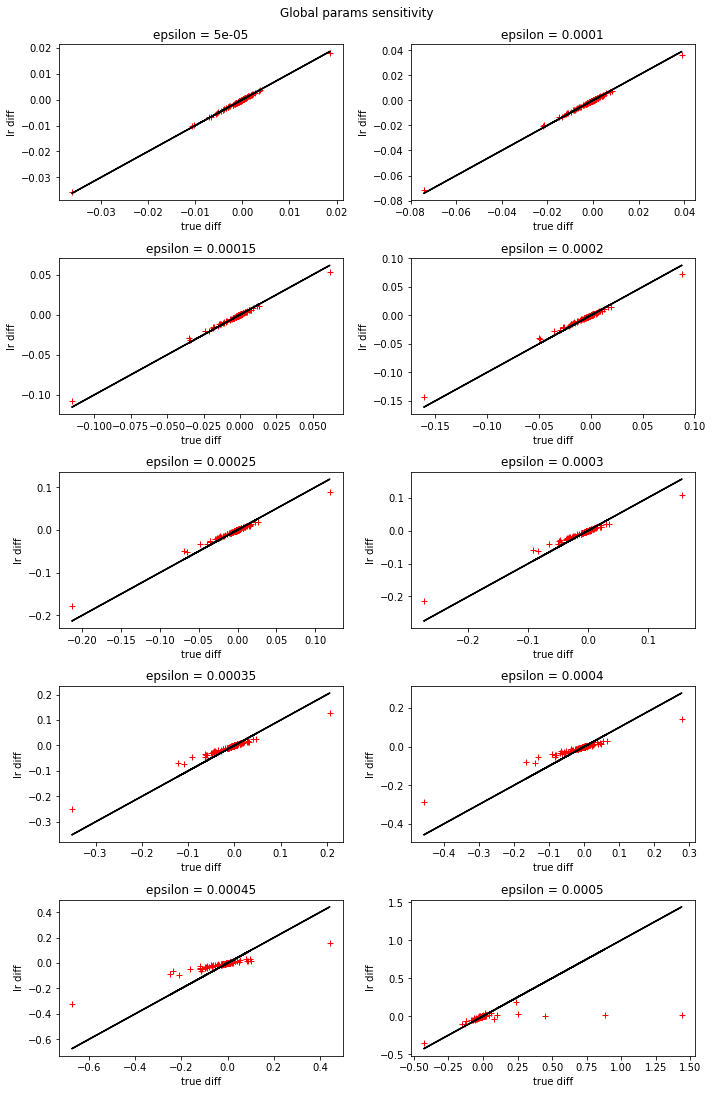

In [196]:
# check global params

linear_sens.moment_model.set_moments_from_free_par(best_param)

fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x))

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
        
    # get linear response global free params
    lr_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])

    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list2[i] - best_param).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


(0.0, 0.0005200000000000001)

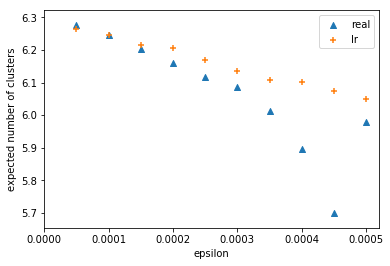

In [205]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list2[i])
    
    lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.xlim((0.0, epsilons[-1]+0.00002))

# Worst case influence

In [89]:
alpha = prior_params['alpha'].get()

In [94]:
total_infl_fun = deepcopy(linear_sens.total_influence_function)

In [95]:
integrand_pos = lambda x : np.maximum(np.dot(g_eta_nclust, total_infl_fun(x)), 0) ** 2 * \
           sp.stats.beta.pdf(x, 1, alpha)


integrand_neg = lambda x : np.maximum(-np.dot(g_eta_nclust, total_infl_fun(x)), 0) ** 2 * \
           sp.stats.beta.pdf(x, 1, alpha)


In [96]:
n_samples = int(1e5)

In [97]:
norm_pos = np.mean(integrand_pos(np.random.rand(n_samples)))
print(norm_pos)

171.87361969996917


In [99]:
norm_neg = np.mean(integrand_neg(np.random.rand(n_samples)))
print(norm_neg)

5228.414367787484


In [100]:
worst_case = lambda x : integrand_neg(x) / norm_neg

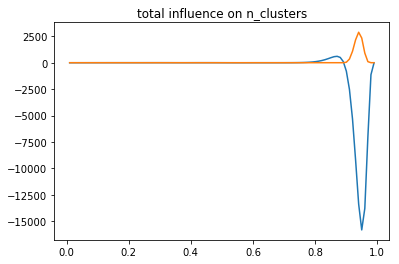

In [101]:
plt.plot(theta, total_influence_n_clust)
plt.plot(theta, worst_case(theta) * 100)

plt.title('total influence on n_clusters')

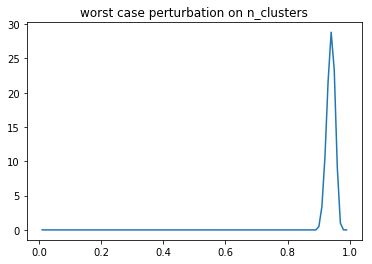

In [102]:
plt.plot(theta, worst_case(theta))
plt.title('worst case perturbation on n_clusters')

In [103]:
fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : worst_case(x))

ValueError: setting an array element with a sequence.

In [88]:
# Perturb and re-optimize
model_worst_case_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : worst_case(x) * epsilon)

pert_worst_case_opt_free_param = \
    model_worst_case_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


ValueError: setting an array element with a sequence.